### Imports

In [1]:
import os
import sys
import random

In [2]:
import numpy as np

In [3]:
import torch
from torch.utils.data import Dataset

In [4]:
import torchvision
import torchvision.transforms as transforms

In [5]:
from torchvision.transforms import InterpolationMode

In [26]:
# our library
from svetlanna import SimulationParameters
from svetlanna.parameters import BoundedParameter

In [42]:
# our library
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.setup import LinearOpticalSetup
from svetlanna.detector import Detector, DetectorProcessorClf

In [7]:
# datasets of wavefronts
from src.wf_datasets import WavefrontsDatasetSimple

In [8]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Optical Neural Network

In that example notebook we will try to realize a simple architecture of an optical neural network from [an article](https://www.science.org/doi/10.1126/science.aat8084).

> In general, the phase and amplitude of eachneuron can be learnable parameters, providinga complex-valued modulation at each layer, which improves the inference performance of the diffractive network.

> ... we first trained it as a digit classifierto perform automated classification of hand-written digits, from $0$ to $9$. Forthis task, phase-only transmission masks weredesigned by training **a five-layer** $D^2 NN$ with $55,000$ images ($5000$ validation images) from the MNIST handwritten digit data-base.

>  We then used continuous-wave illumination at $0.4$ $THz$...

Some info from [a supplementary material](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) (information about MNIST classification):

> Because we consider coherent illumination, the input information can be encoded in the amplitude and/or phase channels of the input plane.

> For each layer of the $D^2NN$, we set we set the neuron size to be $400$ $\mu m$...

> At the detector/output plane, we measured the intensity of the network output...

# 1. Simulation parameters

In [9]:
working_frequency = 0.4 * 1e12 # [Hz]
c_const = 299_792_458  # [m / s]

In [10]:
working_wavelength = c_const / working_frequency  # [m]
print(f'lambda = {working_wavelength * 1e6:.3f} um')

lambda = 749.481 um


In [11]:
# physical size of each layer (from the article) - (8 x 8) [cm]
x_layer_size = 8 * 1e-2  # [m]
y_layer_size = x_layer_size

In [12]:
# number of neurons in simulation
neuron_size = 400 * 1e-6  # [m]

x_layer_nodes = int(x_layer_size / neuron_size)
y_layer_nodes = int(y_layer_size / neuron_size)

In [13]:
y_layer_nodes

200

In [14]:
# simulation parameters for the rest of the notebook

sim_params = SimulationParameters(
    x_size=x_layer_size,  # [m]
    y_size=y_layer_size,  # [m]
    x_nodes=x_layer_nodes,
    y_nodes=y_layer_nodes,
    wavelength=working_wavelength,  # [m]
)

# 2. Dataset preparation (Data Engineer)

## 2.1. [MNIST Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

In [15]:
# initialize a directory for a dataset
data_filepath = './data'  # folder to store data

### 2.1.1. Train/Test datasets of images

In [16]:
# TRAIN (images)
mnist_train_ds = torchvision.datasets.MNIST(
    root=data_filepath,
    train=True,  # for train dataset
    download=False,
)

In [17]:
# TEST (images)
mnist_test_ds = torchvision.datasets.MNIST(
    root=data_filepath,
    train=False,  # for test dataset
    download=False,
)

In [18]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


### 2.1.2. Train/Test datasets of wavefronts

In [19]:
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(int(y_layer_nodes / 2), int(x_layer_nodes / 2)),
          interpolation=InterpolationMode.NEAREST,
      ),
  ]  
)

In [20]:
# TRAIN dataset of WAVEFRONTS
mnist_wf_train_ds = WavefrontsDatasetSimple(
    images_ds=mnist_train_ds,  # dataset of images
    image_transforms_comp=image_transform_for_ds,  # image transformation
    sim_params=sim_params,  # simulation parameters
)

In [21]:
# TEST dataset of WAVEFRONTS
mnist_wf_test_ds = WavefrontsDatasetSimple(
    images_ds=mnist_test_ds,  # dataset of images
    image_transforms_comp=image_transform_for_ds,  # image transformation
    sim_params=sim_params,  # simulation parameters
)

In [22]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


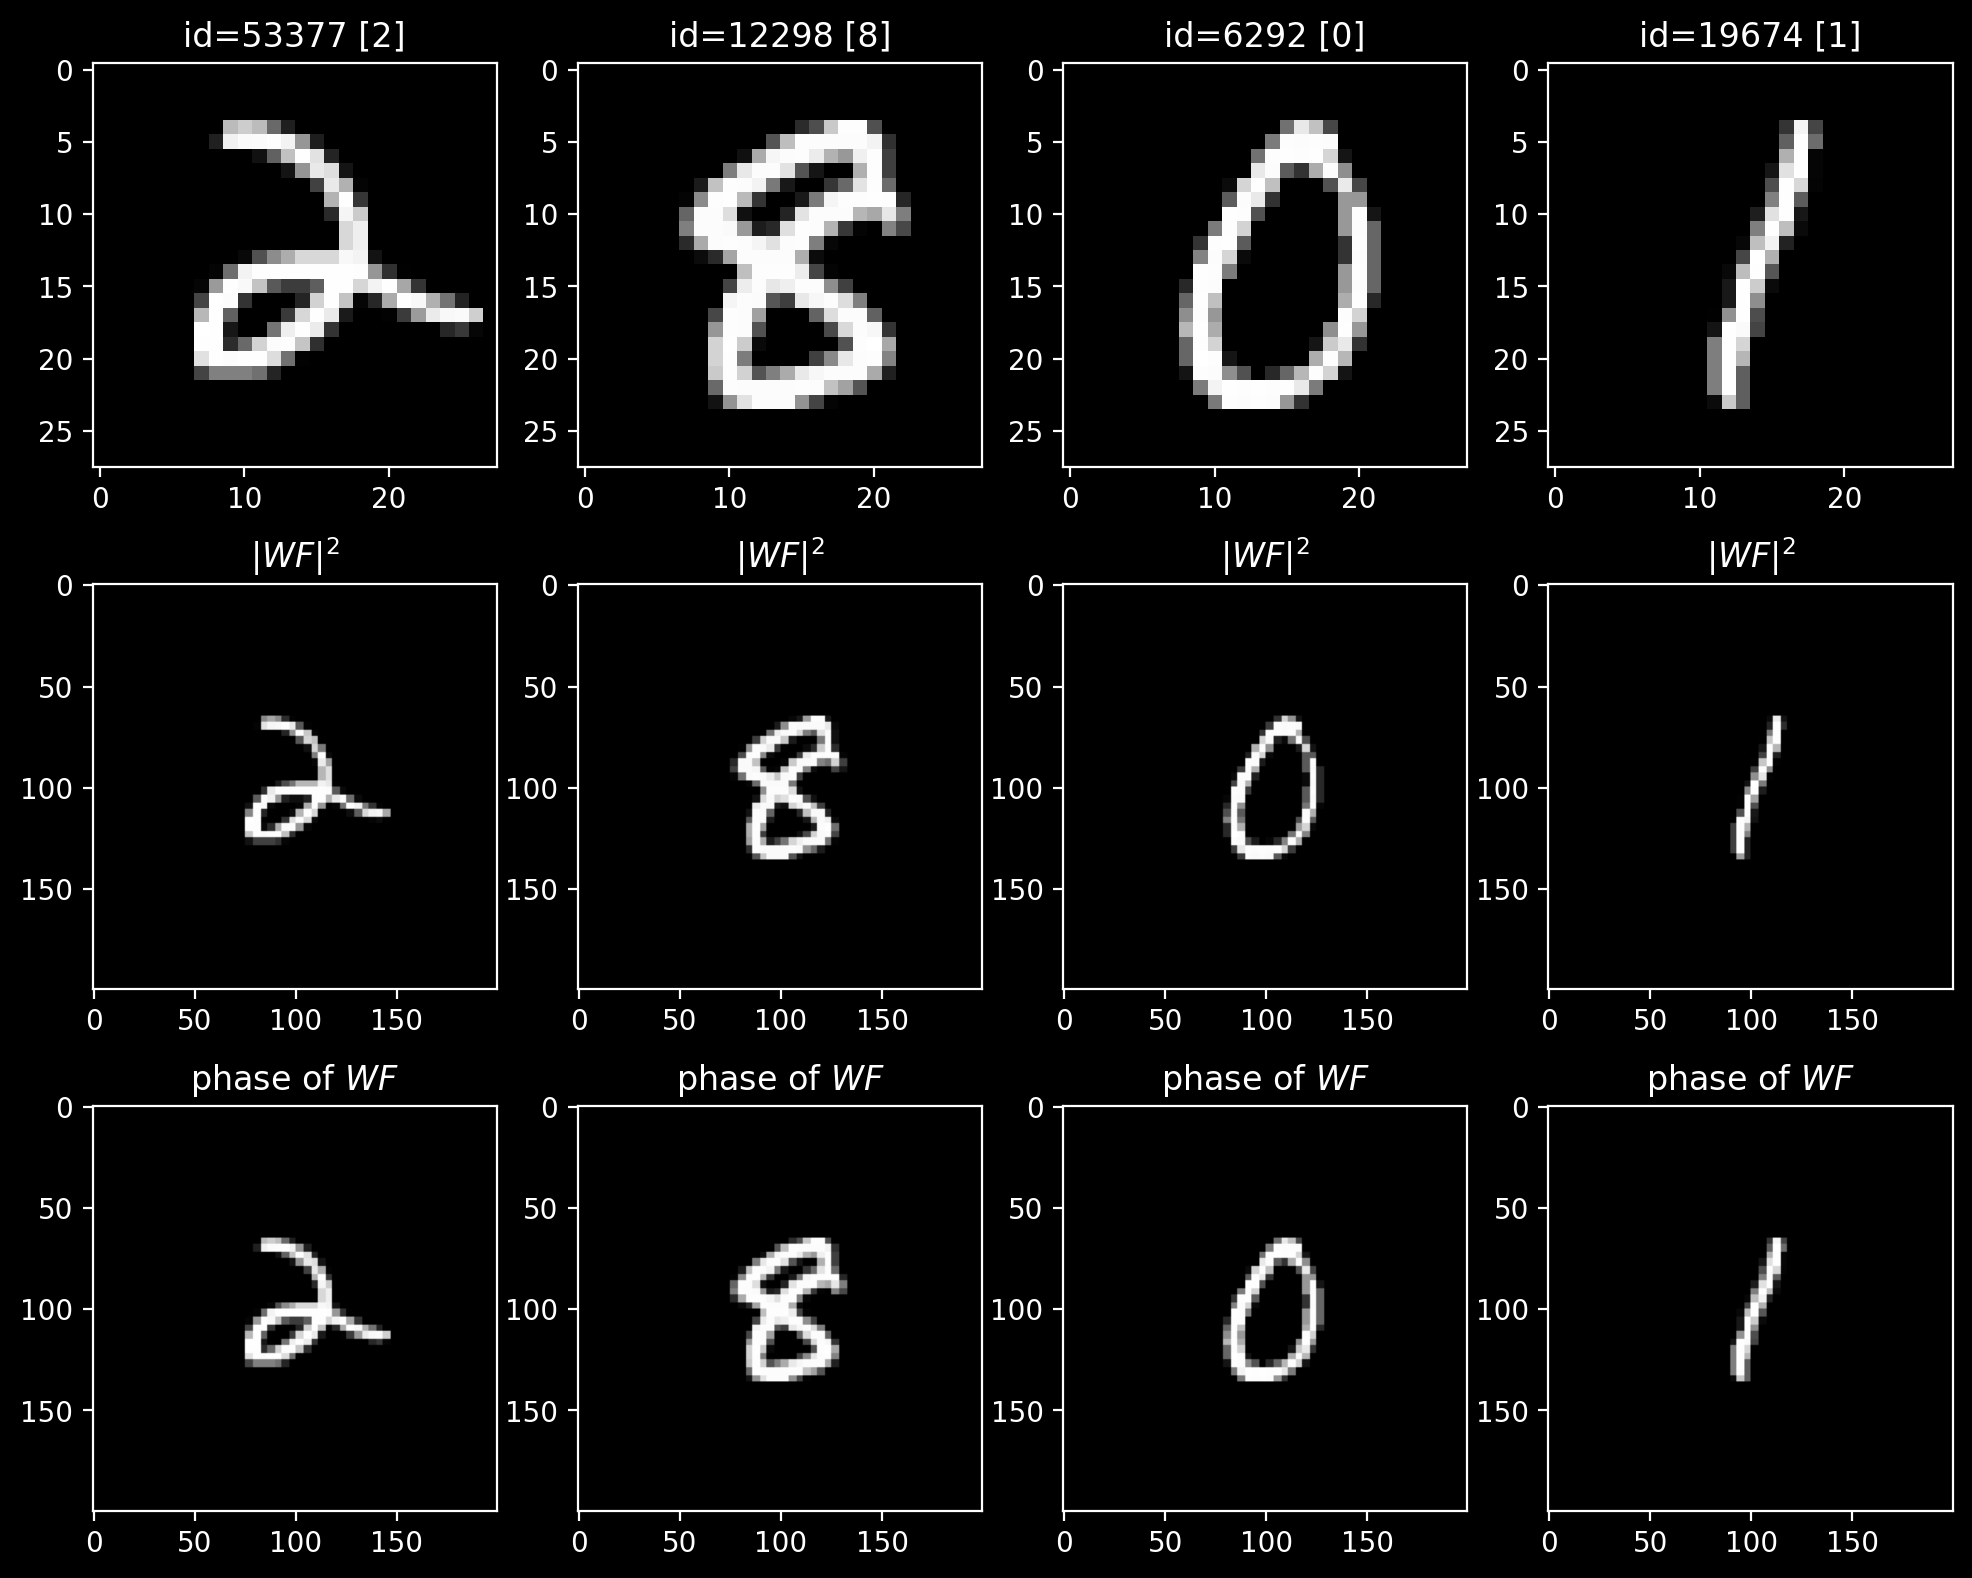

In [25]:
# plot several EXAMPLES from TRAIN dataset
n_examples= 4  # number of examples to plot
# choosing indecies of images (from train) to plot
random.seed(78)
train_examples_ids = random.sample(range(len(mnist_train_ds)), n_examples)

all_examples_wavefronts = []

n_lines = 3
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))
for ind_ex, ind_train in enumerate(train_examples_ids):
    image, label = mnist_train_ds[ind_train]
    
    axs[0][ind_ex].set_title(f'id={ind_train} [{label}]')
    axs[0][ind_ex].imshow(image, cmap='gray')

    wavefront, wf_label = mnist_wf_train_ds[ind_train]
    assert isinstance(wavefront, Wavefront)

    all_examples_wavefronts.append(wavefront)

    axs[1][ind_ex].set_title(f'$|WF|^2$')
    # here we can plot intensity for a wavefront
    axs[1][ind_ex].imshow(wavefront.intensity[0], cmap='gray')
    
    axs[2][ind_ex].set_title(f'phase of $WF$')
    axs[2][ind_ex].imshow(wavefront.phase[0], cmap='gray')

plt.show()

# 3. Optical network architecture

Info from [a supplementary material](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) for MNIST classification:
> We used the stochastic gradient descent algorithm, Adam, to back-propagate the errors and update the
layers of the network to minimize the loss function.

> The training batch size was set to be $8$...

> Following the corresponding $D^2NN$ design, the axial distance between two successive 3D-printed layers was set to be $3.0$ $cm$...

> The distance between detector/output plane and the last layer of the optical neural network was adjusted as $3$ $cm$...

In [39]:
number_of_diffractive_layers = 5  # number of diffractive layers
distance_between_difractive_layers = 3 * 1e-2  # [m]

## 3.1. Architecture
Figure 2A from [the article](https://www.science.org/doi/10.1126/science.aat8084).
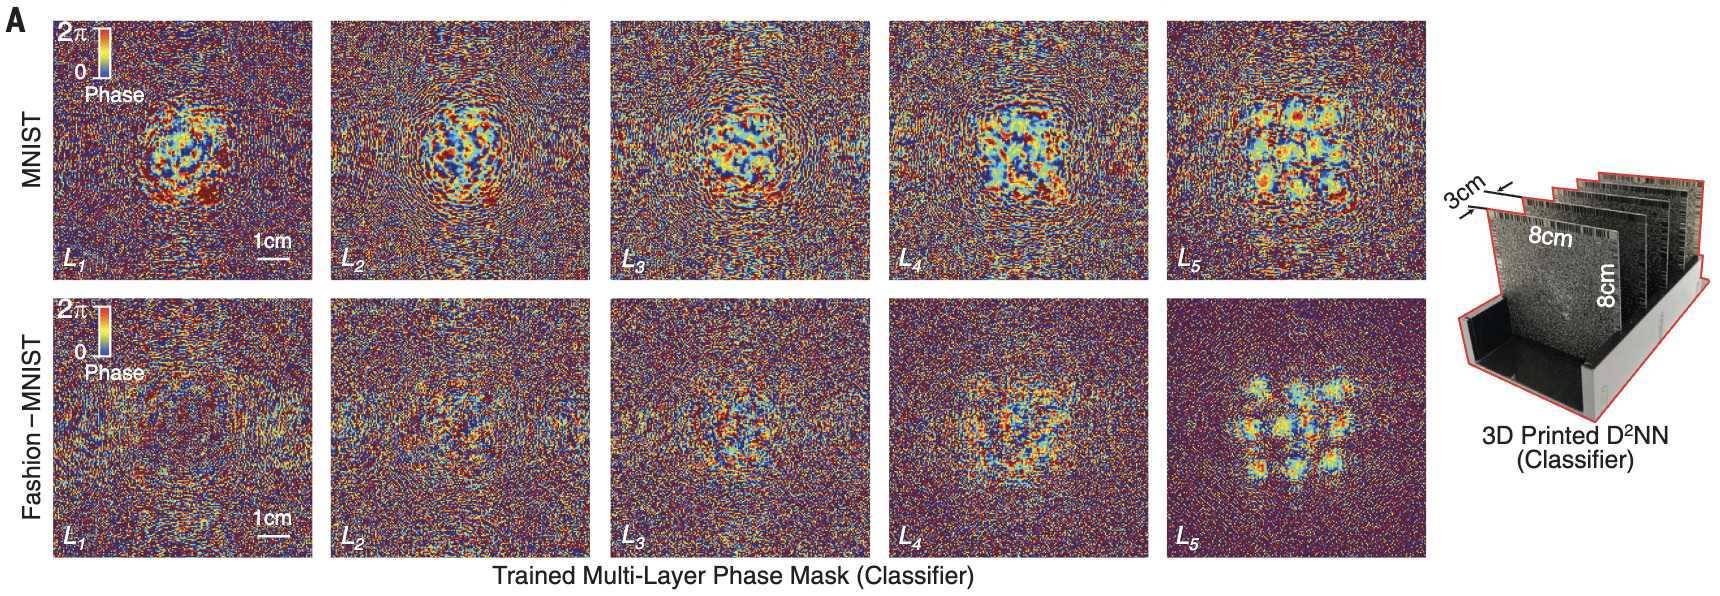

### 3.1.1. List of Elements

In [40]:
def get_const_free_space(
    freespace_sim_params,
    freespace_distance,  # in [m]!
    freespace_method='AS',
):
    """
    Returns FreeSpace layer with a bounded distance parameter.
    """
    return elements.FreeSpace(
        simulation_parameters=freespace_sim_params,
        distance=freespace_distance,  # distance is not learnable!
        method=freespace_method
    )


def get_diffractive_layer(
    difflayer_sim_params
):
    """
    Returns DiffractiveLayer with a random mask.
    """
    random_mask = torch.rand(
        size=(difflayer_sim_params.y_nodes, difflayer_sim_params.x_nodes)
    ) * (2 * np.pi)
    return elements.DiffractiveLayer(
        simulation_parameters=difflayer_sim_params,
        mask=BoundedParameter(
            random_mask,
            min_value=0,
            max_value=2*torch.pi
        ),
        mask_norm=1
    )

In [41]:
architecture_elements_list = []  # list of elements

# compose architecture
for ind_layer in range(number_of_diffractive_layers):
    if ind_layer == 0:
        # first FreeSpace layer before first DiffractiveLayer
        architecture_elements_list.append(
            get_const_free_space(
                sim_params,  # simulation parameters for the notebook
                distance_between_difractive_layers,  # in [m]
                freespace_method='AS',
            )
        )
    # add DiffractiveLayer
    architecture_elements_list.append(
        get_diffractive_layer(
            sim_params,  # simulation parameters for the notebook
        )
    )
    # add FreeSpace
    architecture_elements_list.append(
        get_const_free_space(
            sim_params,  # simulation parameters for the notebook
            distance_between_difractive_layers,  # in [m]
            freespace_method='AS',
        )
    )


# add Detector in the end of the system
architecture_elements_list.append(
    Detector(
        simulation_parameters=sim_params,
        func='intensity'  # detector that returns intensity
    )
)

print(f'Number of elements in the system (including Detector): {len(architecture_elements_list)}')

Number of elements in the system (including Detector): 12


### 3.1.2. Compose `LinearOpticalSetup`

In [43]:
optical_setup = LinearOpticalSetup(
    elements=architecture_elements_list
)

## 3.N. Detector processor

In [78]:
# size of each segment
x_segment_nodes = int(x_layer_nodes / 9)
y_segment_nodes = int(y_layer_nodes / 9)  # each segment of size = (y_segment_nodes, x_segment_nodes)

In [79]:
# coordinates of segments left upper corners (in nodes)
segments_corners = {}

for ind, label in enumerate(range(3)):
    segments_corners[label] = (
        y_layer_nodes // 4 - y_segment_nodes // 2,
        2 * x_segment_nodes + ind * (2 * x_segment_nodes)
    )

for ind, label in enumerate(range(3, 7)):
    segments_corners[label] = (
        y_layer_nodes // 2 - y_segment_nodes // 2,
        x_segment_nodes + ind * (2 * x_segment_nodes)
    )

for ind, label in enumerate(range(7, 10)):
    segments_corners[label] = (
        3 * y_layer_nodes // 4 - y_segment_nodes // 2,
        2 * x_segment_nodes + ind * (2 * x_segment_nodes)
    )

In [80]:
# create a mask for detector
detector_mask = torch.ones(
    size=(y_layer_nodes, x_layer_nodes),
) * (-1)

for label in segments_corners.keys():
    y_node, x_node = segments_corners[label]
    detector_mask[y_node:y_node + y_segment_nodes, x_node:x_node + x_segment_nodes] = label

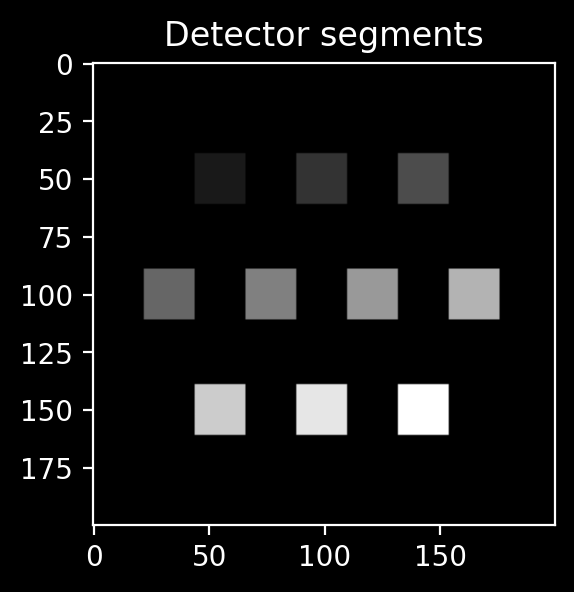

In [84]:
# let's take a look at a beam intensity distribution
fig, ax0 = plt.subplots(1, 1, figsize=(3, 3))

ax0.set_title(f'Detector segments')
ax0.imshow(detector_mask, cmap='grey')

plt.show()